In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split
from custom_preprocessor import preprocess
import json

/var/folders/lx/3tpp7mdx68918pcn6277_wtw0000gn/T/ipykernel_62224/1599806223.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [2]:
df = pd.read_csv('./data/dataset_hellenic.csv')
df = df.sample(frac=1.0, random_state=12)
df.head()

,Word,Language
11,os an oun os an oun os an oun os an oun os an,AncientGreek
422,oste etsi ekhoun oste etsi ekhoun oste etsi,Greek
101,lio tou kuriou lio tou kuriou lio tou kuriou lio,AncientGreek
255,ou distaseis ou distaseis ou distaseis ou,AncientGreek
299,epeide odegei eis epeide odegei eis epeide,AncientGreek


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [3]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
print(f"Input dimension: {input_dim}")
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_df = pd.get_dummies(df.iloc[:, -1:])
y = y_df.values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

Input dimension: 48
Rows: 680
Amount of languages to identify: 2


In [4]:
model = Sequential()
model.add(Conv1D(input_dim, 2, activation='relu'))  # Convolutional layer
model.add(LSTM(32, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [5]:
history = model.fit(X_train.astype('float32'), y_train.astype('float32'), validation_data=(X_val, y_val), epochs=300, batch_size=2048,verbose=1)

Epoch 1/300
1/1 [==============================] - 1s 1s/step - loss: 0.7462 - accuracy: 0.4835 - val_loss: 3.8545 - val_accuracy: 0.4632
Epoch 2/300
1/1 [==============================] - 0s 62ms/step - loss: 3.5770 - accuracy: 0.5092 - val_loss: 0.6926 - val_accuracy: 0.5221
Epoch 3/300
1/1 [==============================] - 0s 69ms/step - loss: 0.7236 - accuracy: 0.4871 - val_loss: 0.9198 - val_accuracy: 0.5368
Epoch 4/300
1/1 [==============================] - 0s 71ms/step - loss: 0.9960 - accuracy: 0.4908 - val_loss: 0.7051 - val_accuracy: 0.5294
Epoch 5/300
1/1 [==============================] - 0s 71ms/step - loss: 0.7208 - accuracy: 0.4908 - val_loss: 0.9285 - val_accuracy: 0.4632
Epoch 6/300
1/1 [==============================] - 0s 70ms/step - loss: 0.8710 - accuracy: 0.5092 - val_loss: 0.8295 - val_accuracy: 0.4632
Epoch 7/300
1/1 [==============================] - 0s 69ms/step - loss: 0.7911 - accuracy: 0.5092 - val_loss: 0.7227 - val_accuracy: 0.4559
Epoch 8/300
1/1 [=====

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

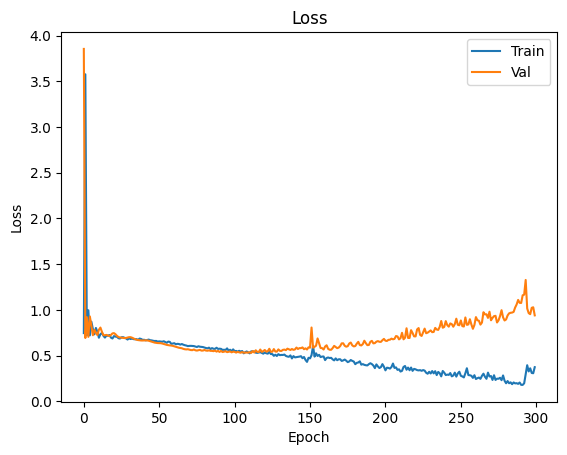

In [6]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

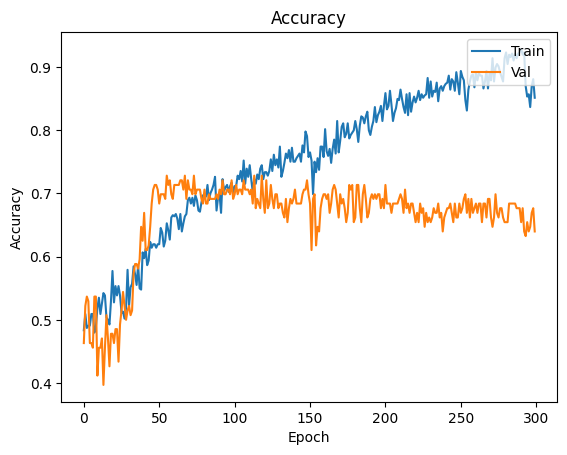

In [7]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Prediction

In [8]:
prediction_word = "Πηλικὸς εἶ"
print(f"Text before preprocessing: {prediction_word}")
prediction_word = preprocess(prediction_word)
print(f"Text after preprocessing: {prediction_word}")
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)
result = {}
class_labels = np.unique(y_df.columns)
for index, prediction in enumerate(output_probabilities[0]):
    result.update({class_labels[index]: round(prediction * 100, 1)})

# Print keys and values of the result dictionary
for key, value in result.items():
    print(f"{key}: {value}")

Text before preprocessing: Πηλικὸς εἶ
Text after preprocessing: pelikos ei pelikos ei pelikos ei pelikos ei
1/1 [==============================] - 0s 218ms/step
Language_AncientGreek: 34.3
Language_Greek: 65.7


# Save model
Here a model can be loaded

In [9]:
model.save('./models/model_hellenic.keras')

# Load model
Here a model can be loaded

In [10]:
model = load_model('./models/model_hellenic.keras')
tokenizer_json = tokenizer.to_json()
with open('./tokenizer_configs/tokenizer_config_hellenic.json', 'w') as config_file:
    config_file.write(json.dumps(tokenizer_json, ensure_ascii=False))